In [1]:
import csv
from nltk import ngrams
import string
import re
import pickle as pkl
import numpy as np

In [2]:
!pip install nltk

In [3]:
data_val = []
with open('snli_val.tsv','r', encoding = 'utf-8', newline = '') as file:
    tsvreader = csv.reader(file, delimiter='\t')
    data_val = [line for line in tsvreader]
    
data_train = []
with open('snli_train.tsv','r', encoding = 'utf-8', newline = '') as file:
    tsvreader = csv.reader(file, delimiter='\t')
    data_train = [line for line in tsvreader]

In [4]:
print("Train dataset size is {}".format(len(data_train)))
print("Validation dataset size is {}".format(len(data_val)))

Train dataset size is 100001
Validation dataset size is 1001


In [5]:
data_val_s1, data_val_s2, data_val_label = zip(*data_val)
data_train_s1, data_train_s2, data_train_label = zip(*data_train)

In [6]:
data_val_s1 = data_val_s1[1:]
data_val_s2 = data_val_s2[1:]
data_val_label = data_val_label[1:]
data_train_s1 = data_train_s1[1:]
data_train_s2 = data_train_s2[1:]
data_train_label = data_train_label[1:]

In [7]:
len(data_val_label)

1000

In [8]:
"""
Tokenize data
"""
def tokenize_ngrams(sent):
    #tokens = ngrams(re.findall(r"[\w']+|[.,!?;():~@+-<>#]", sent.lower()),n)
    tokens = ngrams([gram for gram in re.findall(r"[\w']+|[.,!?;():~@+-<>#]*", sent.lower())
                     if (gram not in string.punctuation)], 1)
    return [token[0] for token in tokens]

def tokenize_dataset_ngrams(dataset):
    all_tokens = []
    token_dataset = []
    for sample in dataset:
        tokens = tokenize_ngrams(sample)
        token_dataset.append(tokens)
        all_tokens += tokens
    return token_dataset, all_tokens
    
def convert_labels(dataset_label):
    """Convert labels from number
       entails  --> 1
       contradiction --> -1
       neural --> 0
    """
    labels = []
    for l in dataset_label:
        if l == 'entailment':
            labels.append(2)
        elif l == 'contradiction':
            labels.append(0)
        elif l == 'neutral':
            labels.append(1)
        elif l=='label':
            labels.append('label')
    return labels
            

In [9]:
data_val_s1_tokens, _ = tokenize_dataset_ngrams(data_val_s1)
data_val_s2_tokens, _ = tokenize_dataset_ngrams(data_val_s2)
data_val_label0 = convert_labels(data_val_label)
data_train_s1_tokens, all_train_s1_tokens = tokenize_dataset_ngrams(data_train_s1)
data_train_s2_tokens, all_train_s2_tokens = tokenize_dataset_ngrams(data_train_s2)
data_train_label0 = convert_labels(data_train_label)

In [10]:
all_train_tokens = all_train_s1_tokens + all_train_s2_tokens
print("Total number of all tokens in train dataset is {}".format(len(all_train_tokens)))

Total number of all tokens in train dataset is 2037612


In [11]:
print(len(data_val_label0))

1000


In [12]:
"""Build Vocabulary"""
from collections import Counter

max_vocab_size = 20000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size-2))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [13]:
if len(token2id)< max_vocab_size:
    max_vocab_size = len(token2id)

In [14]:
print(len(token2id))

19581


In [15]:
"""Load pretrained embedding matrix"""

words_to_load = 200000

with open('wiki-news-300d-1M.vec', 'r', encoding = 'utf-8') as f:
    embedding_matrix = np.zeros([words_to_load, 300])
    word2id_emb = {}
    id2word_emb = []
    next(f)
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        id2word_emb.append(s[0])
        word2id_emb[s[0]] = 0
        embedding_matrix[i] = np.asarray(s[1:])

print("Embedding_matrix shape is {}".format(embedding_matrix.shape))
print("Embedding Vocabualry size is {}".format(len(id2word_emb)))

Embedding_matrix shape is (200000, 300)
Embedding Vocabualry size is 200000


In [16]:
"""Build pretrained Embedding Matrix"""
pre_emb_matrix = np.zeros([max_vocab_size, 300])

i = 0
for word in id2token:
    try:
        id_pretrain = word2id_emb[word]
        pre_emb_matrix[token2id[word]] = embedding_matrix[id_pretrain]
    except KeyError:
        pre_emb_matrix[token2id[word]] = np.zeros(300)
        i = i+1
print("{} tokens appear in the pretrained dataset".format(1-i/max_vocab_size))

0.8282008069046525 tokens appear in the pretrained dataset


In [17]:
pre_emb_matrix.shape

(19581, 300)

In [18]:
# convert token to id in the dataset
def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [19]:
data_val_s1_indices = token2index_dataset(data_val_s1_tokens, token2id)
data_val_s2_indices = token2index_dataset(data_val_s2_tokens, token2id)
data_train_s1_indices = token2index_dataset(data_train_s1_tokens, token2id)
data_train_s2_indices = token2index_dataset(data_train_s2_tokens, token2id)

In [20]:
len(data_val_s1_indices), len(data_train_s2_indices), len(data_train_label0)

(1000, 100000, 100000)

Create Dataset

In [21]:
from torch.utils.data import Dataset

In [22]:
class SNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_list_s1, data_list_s2, data_label_list):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.s1_list, self.s2_list, self.label_list = data_list_s1, data_list_s2, data_label_list
        assert ((len(self.s1_list) == len(self.label_list)) and (len(self.s1_list) == len(self.s2_list)))

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        return [self.s1_list[key], self.s2_list[key], max(len(self.s1_list[key]), len(self.s2_list[key])), self.label_list[key]]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    s1_list = []
    s2_list = []
    label_list = []
    length_list = []

    for datum in batch:
        label_list.append(datum[3])
        length_list.append(datum[2])
    # padding
    #MAX_WORD_LENGTH
    max_length = max(length_list)
    for datum in batch:
        padded_vec_s1 = np.pad(np.array(datum[0]),
                                pad_width=((0,max_length-len(datum[0]))),
                                mode="constant", constant_values=0)
        padded_vec_s2 = np.pad(np.array(datum[1]),
                                pad_width=((0,max_length-len(datum[1]))),
                                mode="constant", constant_values=0)
        s1_list.append(padded_vec_s1)
        s2_list.append(padded_vec_s2)
    ind_dec_order = np.argsort(length_list)[::-1]
    s1_list = np.array(s1_list)[ind_dec_order]
    s2_list = np.array(s2_list)[ind_dec_order]
    length_list = np.array(length_list)[ind_dec_order]
    label_list = np.array(label_list)[ind_dec_order]
    return [torch.from_numpy(np.array(s1_list)), torch.from_numpy(np.array(s2_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]



In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

BATCH_SIZE = 32

In [24]:
train_dataset = SNLIDataset(data_train_s1_indices, data_train_s2_indices, data_train_label0)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = SNLIDataset(data_val_s1_indices, data_val_s2_indices, data_val_label0)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

Build CNN model

In [25]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, kernal_size, num_classes, vocab_size, pretrained_weight):

        super(CNN, self).__init__()
        
        linear_size1 = 20
        padding_size = int((kernal_size-1)/2)
        
        self.num_layers, self.hidden_size, self.kernal_size = num_layers, hidden_size, kernal_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weight))
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernal_size, padding=padding_size)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernal_size, padding=padding_size)

        self.linear1 = nn.Linear(2*hidden_size, linear_size1)
        self.linear2 = nn.Linear(linear_size1, num_classes)

    def forward(self, s1, s2, lengths):
        batch_size, seq_len = s1.size()

        embed_s1 = self.embedding(s1)
        embed_s2 = self.embedding(s2)
        
        hidden_s1 = self.conv1(embed_s1.transpose(1,2)).transpose(1,2)
        hidden_s1 = F.relu(hidden_s1.contiguous().view(-1, hidden_s1.size(-1))).view(batch_size, seq_len, hidden_s1.size(-1))

        hidden_s1 = self.conv2(hidden_s1.transpose(1,2)).transpose(1,2)
        hidden_s1 = F.relu(hidden_s1.contiguous().view(-1, hidden_s1.size(-1))).view(batch_size, seq_len, hidden_s1.size(-1))

        hidden_s1 = torch.sum(hidden_s1, dim=1)
        
        hidden_s2 = self.conv1(embed_s2.transpose(1,2)).transpose(1,2)
        hidden_s2 = F.relu(hidden_s2.contiguous().view(-1, hidden_s2.size(-1))).view(batch_size, seq_len, hidden_s2.size(-1))

        hidden_s2 = self.conv2(hidden_s2.transpose(1,2)).transpose(1,2)
        hidden_s2 = F.relu(hidden_s2.contiguous().view(-1, hidden_s2.size(-1))).view(batch_size, seq_len, hidden_s2.size(-1))

        hidden_s2 = torch.sum(hidden_s2, dim=1)
        
        hidden = torch.cat((hidden_s1, hidden_s2),-1)
        
        hidden = self.linear1(hidden)
        hidden = F.relu(hidden)
        
        logits = self.linear2(hidden)
        
        return logits

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [27]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1, s2, lengths, labels in loader:
        s1_batch, s2_batch, lengths_batch, label_batch = s1, s2, lengths, labels
        outputs = F.softmax(model(s1_batch, s2_batch, lengths_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)



In [28]:
def test_model2(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    total_loss = 0
    criterion_test = nn.CrossEntropyLoss()
    
    model.eval()
    for s1, s2, lengths, labels in loader:
        s1_batch, s2_batch, lengths_batch, label_batch = s1.to(device), s2.to(device), lengths.to(device), labels.to(device)
        probability = model(s1_batch, s2_batch, lengths_batch)
        loss_test = float(criterion_test(probability, label_batch))
        total_loss += loss_test
        outputs = F.softmax(probability, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += label_batch.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return (100 * correct / total), total_loss/len(loader)

In [35]:
HIDDEN_SIZE = 200
Kernal_size = 3
result_FILE = 'result/cnn_hs'+str(HIDDEN_SIZE) +'_ks' + str(Kernal_size) +'.p'
figname = 'result/cnn_acc_hs'+str(HIDDEN_SIZE) +'_ks' + str(Kernal_size) +'.pdf'
model_name = 'result/model_cnn_hs'+str(HIDDEN_SIZE) +'_ks' + str(Kernal_size) +'.pt'
result_FILE, figname, model_name

('result/cnn_hs100_ks5.p',
 'result/cnn_acc_hs100_ks5.pdf',
 'result/model_cnn_hs100_ks5.pt')

In [36]:
model = CNN(emb_size = 300, hidden_size = HIDDEN_SIZE, num_layers=2, kernal_size = Kernal_size,
            num_classes = 3, vocab_size = pre_emb_matrix.shape[0], pretrained_weight = pre_emb_matrix).to(device)

In [37]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

6078583


In [30]:
best_val_acc = 0

In [31]:
learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_record = []
train_acc_record = []
val_loss_record = []
train_loss_record = []
step_record = []

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (s1, s2, lengths, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1.to(device), s2.to(device), lengths.to(device))
        loss = criterion(outputs, labels.to(device))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 300 == 0:
            # validate
            val_acc, val_loss = test_model2(val_loader, model)
            val_acc_record.append(val_acc)
            val_loss_record.append(val_loss)
            train_acc, train_loss = test_model2(train_loader, model)
            train_acc_record.append(train_acc)
            train_loss_record.append(train_loss)
            step_record.append(i + epoch*total_step)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            if val_acc > best_val_acc:
                with open(model_name, 'wb') as f:
                    torch.save(model, f)
                    best_val_loss = val_loss

training_curve = zip(step_record, train_acc_record, train_loss_record, val_acc_record, val_loss_record)
pkl.dump(training_curve, open(result_FILE, "wb"))

Epoch: [1/10], Step: [301/3125], Validation Acc: 47.4


/home/ml5893/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/10], Step: [601/3125], Validation Acc: 53.0
Epoch: [1/10], Step: [901/3125], Validation Acc: 52.7
Epoch: [1/10], Step: [1201/3125], Validation Acc: 58.0
Epoch: [1/10], Step: [1501/3125], Validation Acc: 61.6
Epoch: [1/10], Step: [1801/3125], Validation Acc: 62.9
Epoch: [1/10], Step: [2101/3125], Validation Acc: 62.0
Epoch: [1/10], Step: [2401/3125], Validation Acc: 62.8
Epoch: [1/10], Step: [2701/3125], Validation Acc: 63.5
Epoch: [1/10], Step: [3001/3125], Validation Acc: 64.5
Epoch: [2/10], Step: [301/3125], Validation Acc: 64.1
Epoch: [2/10], Step: [601/3125], Validation Acc: 65.1
Epoch: [2/10], Step: [901/3125], Validation Acc: 63.4
Epoch: [2/10], Step: [1201/3125], Validation Acc: 64.5
Epoch: [2/10], Step: [1501/3125], Validation Acc: 63.2
Epoch: [2/10], Step: [1801/3125], Validation Acc: 64.2
Epoch: [2/10], Step: [2101/3125], Validation Acc: 63.8
Epoch: [2/10], Step: [2401/3125], Validation Acc: 64.5
Epoch: [2/10], Step: [2701/3125], Validation Acc: 65.7
Epoch: [2/10], 

In [32]:
import matplotlib.pyplot as plt

In [41]:
step_record = []

for epoch in range(10):
    for i in range(3125):
        if i>0 and i % 300 == 0:
            step_record.append(i + epoch*total_step)
len(step_record)

100

In [39]:
training_curve = zip(step_record, train_acc_record, train_loss_record, val_acc_record, val_loss_record)
pkl.dump(training_curve, open(result_FILE, "wb"))

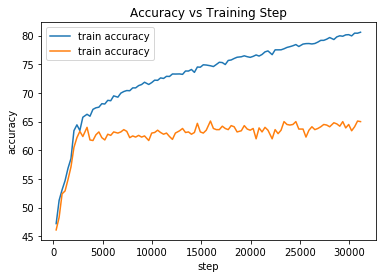

In [80]:
plt.plot(step_record, train_acc_record, label = 'train accuracy')
plt.plot(step_record, val_acc_record, label = 'train accuracy')
plt.legend()
plt.title("Accuracy vs Training Step")
plt.xlabel("step")
plt.ylabel("accuracy")
plt.savefig(figname)
plt.show()

In [30]:
with open(model_name, 'rb') as f:
    best_model = torch.load(f)

In [53]:
val_loader0 = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=1,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

In [61]:
n = 0

for s1, s2, lengths, labels in val_loader0:
    s1_batch, s2_batch, lengths_batch, label_batch = s1.to(device), s2.to(device), lengths.to(device), labels.to(device)
    outputs = F.softmax(best_model(s1_batch, s2_batch, lengths_batch), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    print(n, " True label: ", labels.data.numpy()[0], "  Predicted label: ", (predicted.data).to('cpu').numpy()[0][0])
    n = n+1
    if n>10:
        break

0  True label:  0   Predicted label:  2
1  True label:  2   Predicted label:  2
2  True label:  2   Predicted label:  2
3  True label:  2   Predicted label:  0
4  True label:  2   Predicted label:  0
5  True label:  2   Predicted label:  0
6  True label:  2   Predicted label:  0
7  True label:  0   Predicted label:  0
8  True label:  1   Predicted label:  2
9  True label:  0   Predicted label:  2
10  True label:  2   Predicted label:  2


Incorrect Prediction

In [47]:
data_val_s1[0], data_val_s2[0], data_val_label[0]

('Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .',
 'There are two women standing on the stage',
 'contradiction')

In [48]:
data_val_s1[3], data_val_s2[3], data_val_label[3]

('Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .',
 'Multiple people are on a subway together , with each of them doing their own thing .',
 'entailment')

In [62]:
data_val_s1[8], data_val_s2[8], data_val_label[8]

('A group of numbered participants walk down the street together .',
 'Participants wait for the beginning of the walkathon .',
 'neutral')

Correct Prediction

In [65]:
data_val_s1[1], data_val_s2[1], data_val_label[1]

('Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .',
 'Multiple people are on a subway together , with each of them doing their own thing .',
 'entailment')

In [64]:
data_val_s1[2], data_val_s2[2], data_val_label[2]

('bicycles stationed while a group of people socialize .',
 'People get together near a stand of bicycles .',
 'entailment')

In [66]:
data_val_s1[7], data_val_s2[7], data_val_label[7]

('Two women , one walking her dog the other pushing a stroller .',
 'There is a snowstorm .',
 'contradiction')

Evaluating on MultiNLI

In [31]:
!ls

all_train_tokens.p   hw2_rnn_1-Copy1.ipynb  pre_emb_matrix
data_train_tokens.p  hw2_rnn_1.ipynb	    result
data_val_tokens.p    hw2_rnn_2.ipynb	    snli_train.tsv
hw2_cnn-Copy1.ipynb  mnli_train.tsv	    snli_val.tsv
hw2_cnn.ipynb	     mnli_val.tsv	    wiki-news-300d-1M.vec


In [32]:
data_test = []
with open('mnli_val.tsv','r', encoding = 'utf-8', newline = '') as file:
    tsvreader = csv.reader(file, delimiter='\t')
    data_test = [line for line in tsvreader]

In [36]:
len(data_test)

5001

In [37]:
data_test_head = data_test[0]
data_test_head

['sentence1', 'sentence2', 'label', 'genre']

In [38]:
data_test = data_test[1:]
len(data_test)

5000

In [44]:
data_test[0]

["'Not entirely , ' I snapped , harsher than intended .",
 'I spoke more harshly than I wanted to .',
 'entailment',
 'fiction']

In [39]:
s1_test, s2_test, label_test, genre = zip(*data_test)

In [43]:
genre_set = list(set(genre))
genre_set

['slate', 'travel', 'fiction', 'government', 'telephone']

In [48]:
data_t = {'slate': [], 'travel': [], 'fiction': [], 'government': [], 'telephone': []}

In [49]:
for i in range(len(data_test)):
    data_t[data_test[i][-1]].append(data_test[i][:-1])

In [52]:
len(data_t['slate']) + len(data_t['travel']) + len(data_t['fiction']) +len(data_t['government']) +len(data_t['telephone'])

5000

In [ ]:
test_acc = {'slate': 0, 'travel': 0, 'fiction': 0, 'government': 0, 'telephone': 0}

In [53]:
for gen in genre_set:
    print(gen)
    
    data_s1, data_s2, data_label = zip(*data_t[gen])
    data_s1_tokens, _ = tokenize_dataset_ngrams(data_s1)
    data_s2_tokens, _ = tokenize_dataset_ngrams(data_s2)
    data_label0 = convert_labels(data_label)
    
    data_s1_indices = token2index_dataset(data_s1_tokens, token2id)
    data_s2_indices = token2index_dataset(data_s2_tokens, token2id)
    
    test_dataset = SNLIDataset(data_s1_indices, data_s2_indices, data_label0)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)
    test_acc, test_loss = test_model2(test_loader, best_model)
    print(test_acc)

slate
40.818363273453095
travel
45.11201629327902
fiction
40.904522613065325
government
42.224409448818896
telephone
43.38308457711443


In [ ]:
data_val_s1_tokens, _ = tokenize_dataset_ngrams(data_val_s1)
data_val_s2_tokens, _ = tokenize_dataset_ngrams(data_val_s2)
data_val_label0 = convert_labels(data_val_label)

In [ ]:
data_val_s1_indices = token2index_dataset(data_val_s1_tokens, token2id)
data_val_s2_indices = token2index_dataset(data_val_s2_tokens, token2id)
data_train_s1_indices = token2index_dataset(data_train_s1_tokens, token2id)
data_train_s2_indices = token2index_dataset(data_train_s2_tokens, token2id)

In [ ]:
val_dataset = SNLIDataset(data_val_s1_indices, data_val_s2_indices, data_val_label0)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)